In [158]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [160]:
#This purpose of this code is to use Haar cascade to scan the faces from images and use 
test_image_ori = cv2.imread('/Users/lychee/Documents/Data Science Projects/Datasets/Sample Image.jpg')

In [162]:
test_image_ori.shape
# Shows 3 at the end because it uses the keys RGB

(555, 700, 3)

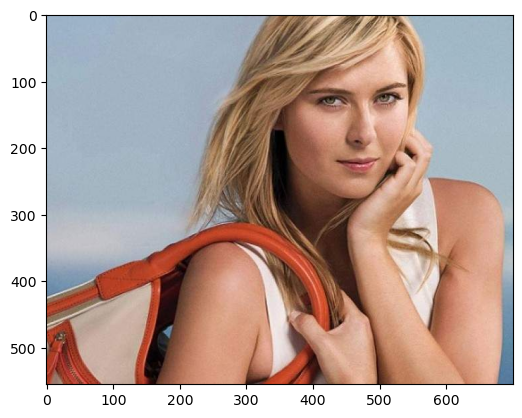

In [164]:
cv2.imshow('Image Window', test_image_ori)
test_image = cv2.cvtColor(test_image_ori, cv2.COLOR_BGR2RGB)
# cv reads images as BGR and matplotlib displays as RBG so we convert BGR to RGB
plt.imshow(test_image)
plt.show()

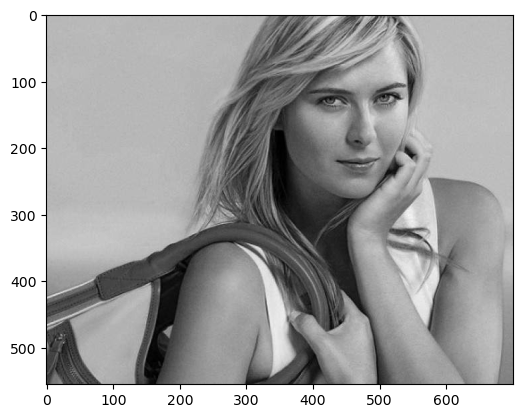

In [166]:
grey_test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# convert to greyscale becuase haar cascade works best with grey images
plt.imshow(grey_test_image, cmap = 'gray')
plt.show()

In [168]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye_tree_eyeglasses.xml')

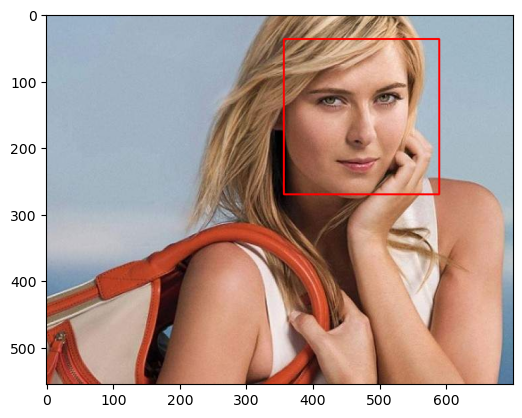

In [170]:
faces = face_cascade.detectMultiScale(grey_test_image, 1.3, 5)
face_detect = test_image.copy()
for face in faces:
    x,y,p1,p2 = face
    face_detect = cv2.rectangle(face_detect,(x,y),(x+p1,y+p2),(255,0,0),2)
plt.imshow(face_detect)
plt.show()

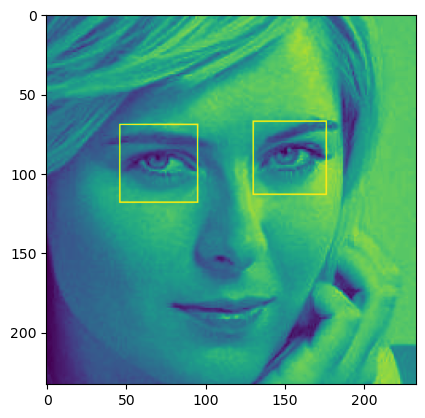

In [172]:
roi_gray = grey_test_image[y:y+p2, x:x+p1]
eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=6)
# minNeighbours measures how sensitive I want the model to be and scaleFactor measures how 
for ex,ey,ep1,ep2 in eyes:
    eyes_detect = cv2.rectangle(roi_gray,(ex,ey),(ex+ep1,ey+ep2),(255,0,0),1)
plt.imshow(eyes_detect)
plt.show()

In [174]:
def get_cropped_image_if_2_eyes(image_path):
    out = []
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, scaleFactor=1.1, minNeighbors=6)
        if len(eyes) >= 2:
            out.append(roi_color)
    if len(out)>=1:
        return out
    return None

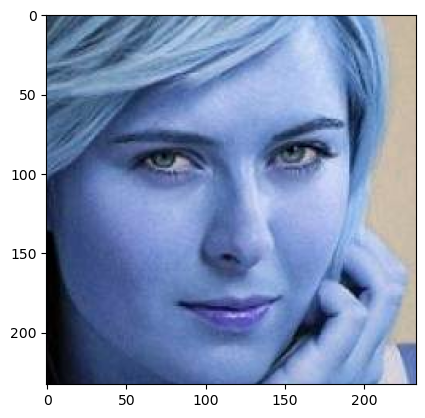

In [190]:
cropped_image_test = get_cropped_image_if_2_eyes('/Users/lychee/Documents/Data Science Projects/Datasets/Sample Image.jpg')
#out is an array of images, we need to index it to 0 to get the image due to the nature of the function above
plt.imshow(cropped_image_test[0])
plt.show()

In [178]:
path_to_data = './Datasets/'
path_to_cropped = './Cropped/'            

In [180]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
# get all the directory names for the images

In [182]:
import shutil
if os.path.exists(path_to_cropped):
     shutil.rmtree(path_to_cropped)
os.mkdir(path_to_cropped)

In [184]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
# create a dictionary with names and a list of images
    
    for entry in os.scandir(img_dir):
        roi_colors = get_cropped_image_if_2_eyes(entry.path)
        if roi_colors is not None:
            for roi_color in roi_colors:
                cropped_folder = path_to_cropped + celebrity_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder: ",cropped_folder)
                    
                cropped_file_name = celebrity_name + str(count) + ".png"
                cropped_file_path = cropped_folder + "/" + cropped_file_name 
                
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1    

John Cena
Generating cropped images in folder:  ./Cropped/John Cena
Error: Unable to load image at ./Datasets/John Cena/.DS_Store
Ronaldo
Generating cropped images in folder:  ./Cropped/Ronaldo
Error: Unable to load image at ./Datasets/Ronaldo/.DS_Store
Winter
Generating cropped images in folder:  ./Cropped/Winter
Gordan Ramsay
Error: Unable to load image at ./Datasets/Gordan Ramsay/.DS_Store
Generating cropped images in folder:  ./Cropped/Gordan Ramsay
Karina
Generating cropped images in folder:  ./Cropped/Karina
Error: Unable to load image at ./Datasets/Karina/.DS_Store


In [214]:
import cv2
import pywt
import numpy as np

#This code defines a function w2d that takes an image and applies wavelet transform-based denoising
#or feature extraction, returning a new image with only high-frequency components (like edges and textures)
def wavelet_trans(img, mode='haar', level=1):
    if img is None or not isinstance(img, np.ndarray):
        raise ValueError("Input image is invalid or None.")
    #Convert the image to greyscale
    imArray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #Convert the pixel values from a range of 0-255 to 0.0-1.0
    imArray = np.float32(imArray) / 255.0
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    #Set low frequency to zero to supress smooth areas and retain only edges or textures
    coeffs_H[0] *= 0
    #Reconstruct the image using only high frequency details
    imArray_H = pywt.waverec2(coeffs_H, mode)
    #Convert pixel values back to 0-255
    imArray_H *= 255
    return np.uint8(imArray_H)

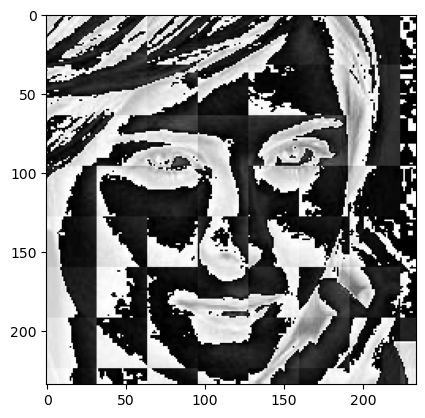

In [216]:
im_har = wavelet_trans(cropped_image_test[0], 'db1', 5)
plt.imshow(im_har, cmap = 'grey')
plt.show()

In [218]:
#Get the number of images per celebrity
class_dict = {}
imag_counter = 0
for celeb_name in celebrity_file_names_dict.keys():
    class_dict[celeb_name] = count
    count += 1
class_dict

{'John Cena': 18,
 'Ronaldo': 19,
 'Winter': 20,
 'Gordan Ramsay': 21,
 'Karina': 22}

In [220]:
#Initialize empty lists for input features (X) and labels (y)
X, y = [], []
for celeb_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            print("Image deleted during cleaning, skipping image")
        #Resize the raw color image to 32x32
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = wavelet_trans(img, 'db1', 5)
        #Resize the wavelet-transformed image to 32x32
        scalled_img_haar = cv2.resize(img_har, (32,32))
        #Verticle stack original image and transformed image so model can train on both
        #Color helps distinguish appearances
        #Wavelet features help detect patterns like edges, textures, and shapes
        comb_img = np.vstack((
            scalled_raw_img.reshape(32*32*3, 1),
            scalled_img_haar.reshape(32*32, 1)
        ))
        X.append(comb_img)
        y.append(class_dict[celeb_name])

In [222]:
len(X)

52